In [2]:
import os
path = "/kaggle/input/mask-or-no-mask/Dataset"

In [6]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Define paths
dataset_path = "/kaggle/input/mask-or-no-mask/Dataset"
base_dir = "/kaggle/working/split_dataset"  # New directory for split data

# Image size & batch size
img_size = (224, 224)  
batch_size = 32  

# Create new split dataset directories
for split in ["train", "val", "test"]:
    for category in os.listdir(dataset_path):  # Iterate through categories
        os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

# Step 1: Count images per category
category_counts = {}
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        category_counts[category] = len(images)

# Print category counts before splitting
print("🔹 **Category Counts Before Splitting:**")
for category, count in category_counts.items():
    print(f"  - {category}: {count} images")

# Step 2: Split images into train (70%), val (15%), test (15%)
for category, count in category_counts.items():
    category_path = os.path.join(dataset_path, category)
    images = os.listdir(category_path)

    # Train-Temp split (70% train, 30% temp)
    train_files, temp_files = train_test_split(images, test_size=0.3, random_state=42, stratify=None)

    # Validation-Test split (50% each of remaining 30%)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42, stratify=None)

    # Move images to respective directories
    for file_name, split in zip(
        [train_files, val_files, test_files], ["train", "val", "test"]
    ):
        for img in file_name:
            src = os.path.join(category_path, img)
            dst = os.path.join(base_dir, split, category, img)
            shutil.copy(src, dst)  # Copy image to new split folder

# Step 3: Data Generators
datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = datagen.flow_from_directory(
    os.path.join(base_dir, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# Print final split sizes
print("\n🔹 **Final Dataset Split:**")
print(f"  - Train Samples: {train_generator.samples}")
print(f"  - Validation Samples: {val_generator.samples}")
print(f"  - Test Samples: {test_generator.samples}")

print("\n🔹 **Class Indices:**", train_generator.class_indices)


🔹 **Category Counts Before Splitting:**
  - without_mask: 2994 images
  - mask_weared_incorrect: 2994 images
  - with_mask: 2994 images
Found 6285 images belonging to 3 classes.
Found 1347 images belonging to 3 classes.
Found 1350 images belonging to 3 classes.

🔹 **Final Dataset Split:**
  - Train Samples: 6285
  - Validation Samples: 1347
  - Test Samples: 1350

🔹 **Class Indices:** {'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load Pretrained MobileNetV2 
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False  

# Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce feature maps to a single vector
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)  # Prevent overfitting
x = Dense(3, activation="softmax")(x)  # 3-class classification

# Define the model
model = Model(inputs=base_model.input, outputs=x)  # Fix: Use 'x' instead of 'output_layer'

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# Train the model
epochs = 20 # You can increase if needed
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


197/197 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.8173 - loss: 0.4778 - val_accuracy: 0.9540 - val_loss: 0.1328
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.9435 - loss: 0.1592 - val_accuracy: 0.9607 - val_loss: 0.1151
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.9533 - loss: 0.1193 - val_accuracy: 0.9681 - val_loss: 0.0931
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.9607 - loss: 0.1010 - val_accuracy: 0.9629 - val_loss: 0.1056
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.9717 - loss: 0.0825 - val_accuracy: 0.9748 - val_loss: 0.0737
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.9760 - loss: 0.0672 - val_accuracy: 0.9681 - val_loss: 0.0966
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.9747 - loss: 0.0642 - val_accuracy: 0.9725 - val_loss: 0.0959
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.9814 - loss: 0.0553 - val_accurac

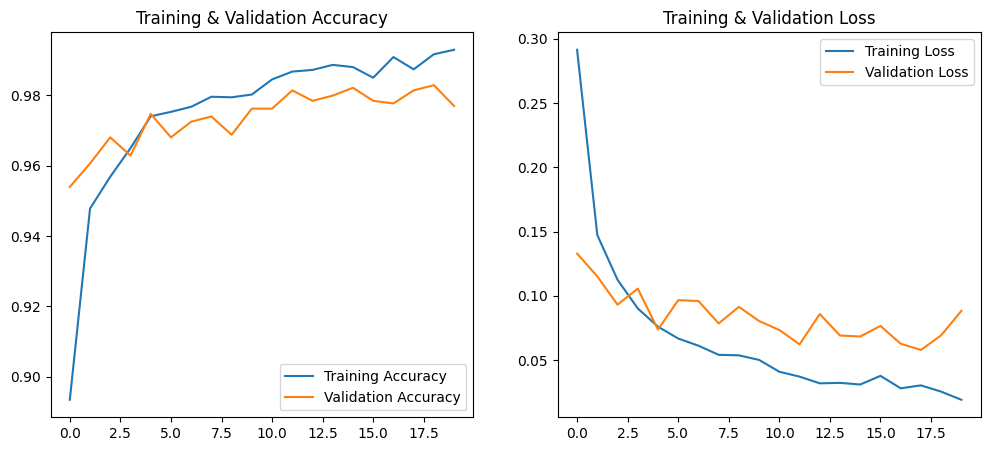

In [10]:
import matplotlib.pyplot as plt

# Extract loss & accuracy from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training & Validation Accuracy")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training & Validation Loss")

plt.show()


In [11]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9836 - loss: 0.0562
Test Accuracy: 97.70%
Test Loss: 0.0871


In [12]:
model.save("MobileNetV2.h5")